In [1]:
import pypsa, numpy as np
import os
import pandas as pd
import csv
import matplotlib.pyplot as plt
#import highspy

C:\Apps\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Several Eastern Caribbean countries with  storage and links, one year of hourly periods, with varying loads and generation from VRE 



In [2]:
#choose the working folders for reading in data and for saving output and figures
csv_folder_name =  "Eastern_CaribbeanExtendableLinksStorage/"
network = pypsa.Network(csv_folder_name)
scenario = "LinksStorage-high_battery_geothermal_cost_b/"

INFO:pypsa.components:Applying weightings to all columns of `snapshot_weightings`
INFO:pypsa.io:Imported network Eastern_CaribbeanExtendableLinksStorage has buses, generators, links, loads, storage_units


In [3]:
#specify use of linopy and solver of choice
network.optimize(solver_name="highs")

INFO:linopy.model: Solve linear problem using Highs solver
INFO:linopy.io:Writing objective.
Writing variables.: 100%|██████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.50it/s]
INFO:linopy.io: Writing time: 14.52s
INFO:linopy.solvers:Log file at C:\Users\Robert Brecha\AppData\Local\Temp\highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 744656 primals, 1664510 duals
Objective: 5.82e+08
Solver model: available
Solver message: optimal



('ok', 'optimal')

In [4]:
#specify folder for saving results, plots
pypsa.Network.export_to_csv_folder(network,scenario)

INFO:pypsa.io:Exported network <unnamed> has generators, links, loads, storage_units, buses


<Axes: xlabel='snapshot'>

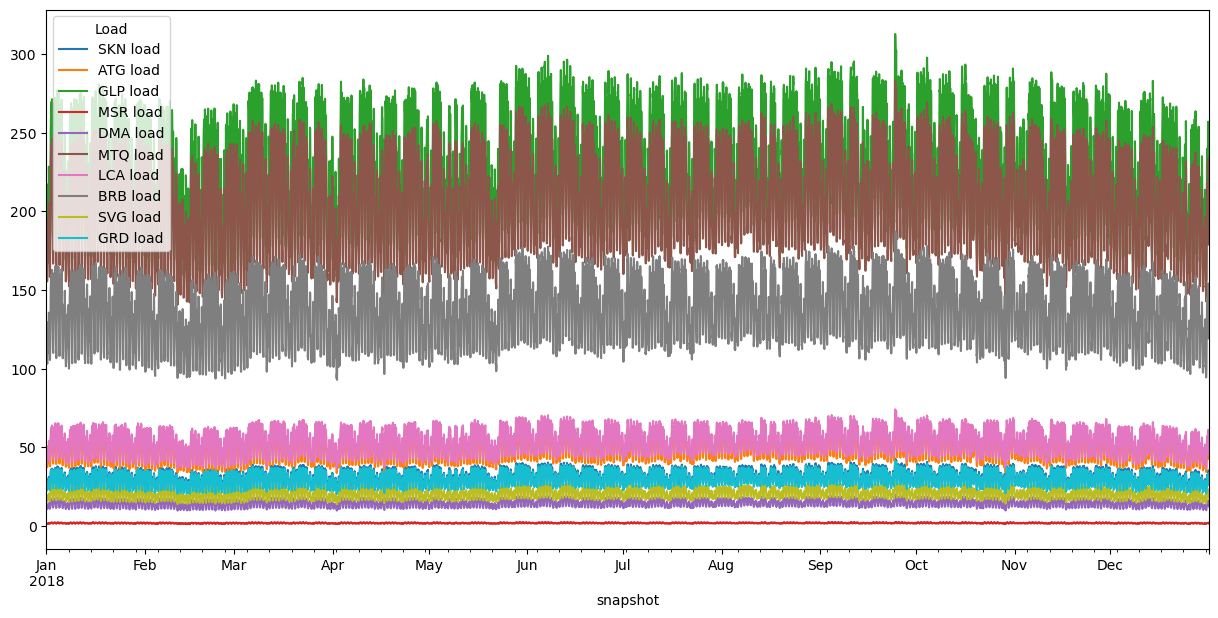

In [5]:
#print the load active power (P) consumption
network.loads_t.p.plot(figsize = (15,7))

<Axes: xlabel='snapshot'>

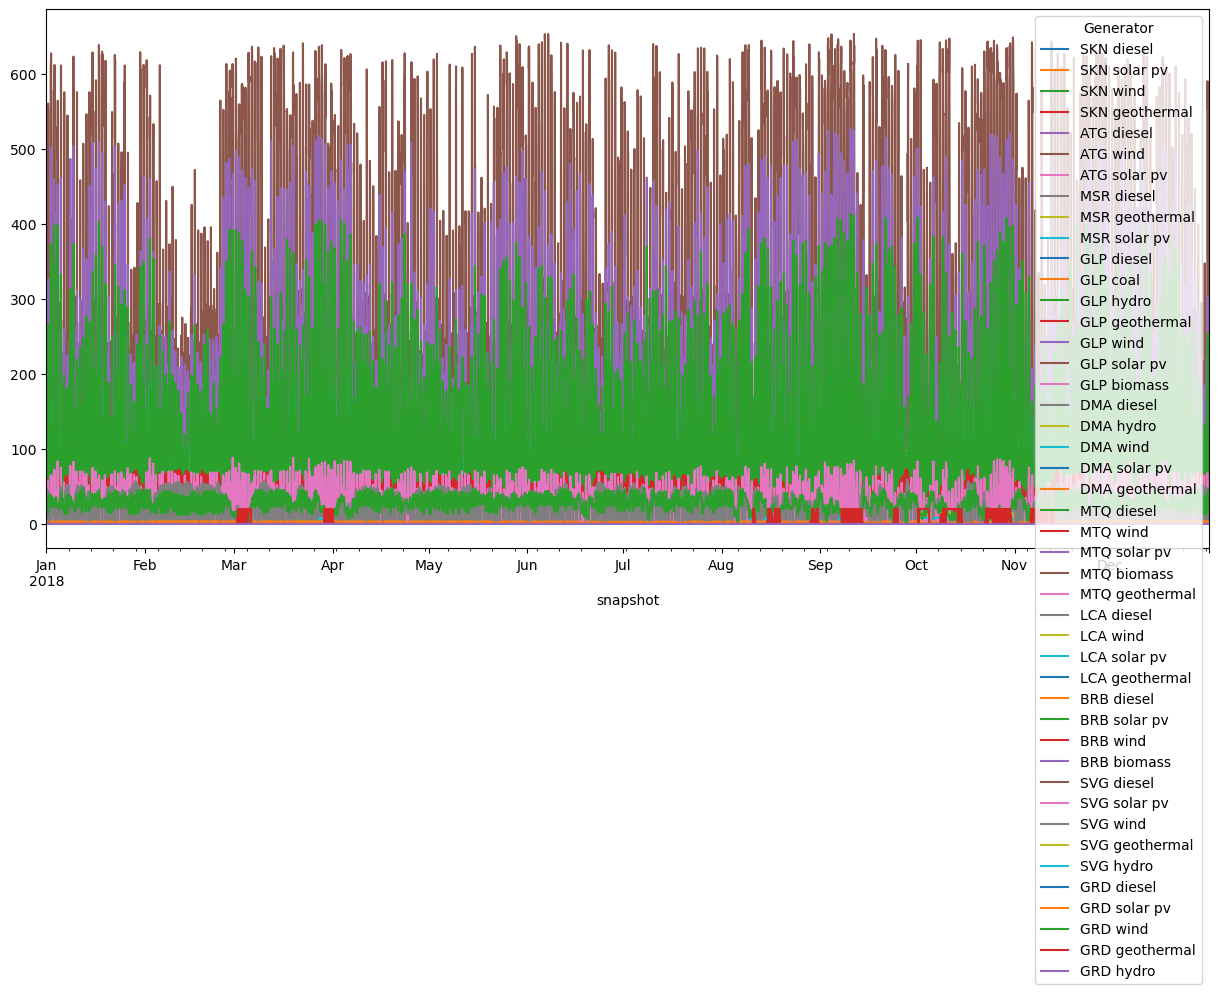

In [6]:
#print the generator active power (P) dispatch if desired
network.generators_t.p.plot(figsize = (15,7))
#network.generators.p_nom_opt

In [7]:
#start manipulation of results for capacities
df_cap=pd.DataFrame(network.generators.p_nom_opt)
df_cap = df_cap.reset_index()

In [8]:
#reshape dataframe for output capacities
df_cap.columns = ['name','Capacity']
new = df_cap["name"].str.split(" ", n = 1, expand = True)
df_cap["Technology"]= new[1]
df_cap['Country']= new[0]
df_cap.drop(columns =["name"], inplace = True)
df_cap= df_cap.pivot(index = 'Country',columns = 'Technology', values = 'Capacity')
df_cap

Technology,biomass,coal,diesel,geothermal,hydro,solar pv,wind
Country,,,,,,,
ATG,NaN,NaN,0.0,NaN,NaN,370.000000,9.731676
BRB,10.0,NaN,0.0,NaN,NaN,570.000000,75.000000
DMA,NaN,NaN,0.0,15.000000,8.0,-0.000000,31.487555
GLP,10.0,-0.0,0.0,50.000000,15.0,1417.897176,203.348492
GRD,NaN,NaN,0.0,20.000000,-0.0,5.454136,60.000000
LCA,NaN,NaN,0.0,30.000000,NaN,297.171387,100.000000
MSR,NaN,NaN,0.0,3.420153,NaN,0.250000,NaN
MTQ,41.4,NaN,0.0,50.000000,NaN,722.037118,200.000000
SKN,NaN,NaN,0.0,19.055592,NaN,111.392552,11.278978


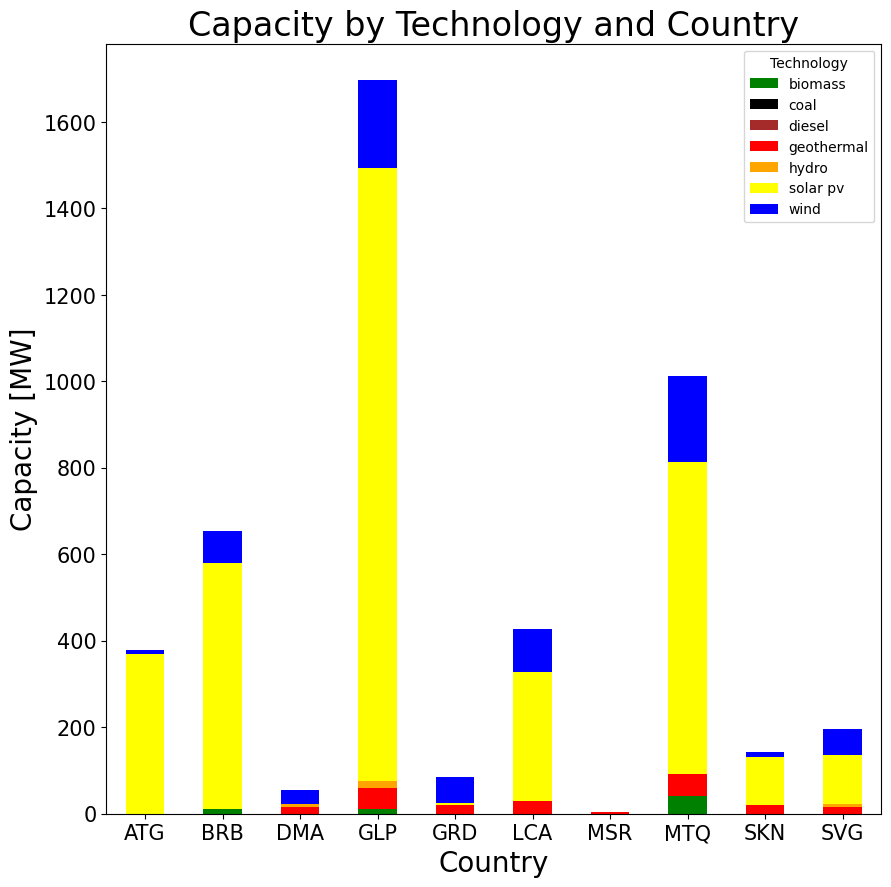

In [9]:
#plot capacity by country and technology
fig, axs = plt.subplots(figsize=(10, 10))        # Create an empty Matplotlib Figure and Axes
df_cap.plot(ax = axs,kind = 'bar', color=['green','black', 'brown', 'red', 'orange','yellow', 'blue'], rot=0,stacked = True)                  # Use pandas to put the area plot on the prepared Figure/Axes
axs.tick_params(axis='both', which='major', labelsize=15)
axs.set_title("Capacity by Technology and Country",fontsize=24)
axs.set_ylabel("Capacity [MW]",fontsize=20)          # Do any Matplotlib customization you like
axs.set_xlabel("Country",fontsize=20) 
fig.savefig(scenario+"capacity.png", bbox_inches='tight')  

In [10]:
#scale capacities to the maximum for each country
df_cap_scaled = df_cap.div(df_cap.sum(axis=1), axis=0)*100
df_cap_scaled

Technology,biomass,coal,diesel,geothermal,hydro,solar pv,wind
Country,,,,,,,
ATG,NaN,NaN,0.0,NaN,NaN,97.437223,2.562777
BRB,1.526718,NaN,0.0,NaN,NaN,87.022901,11.450382
DMA,NaN,NaN,0.0,27.529222,14.682252,-0.000000,57.788526
GLP,0.589537,-0.0,0.0,2.947686,0.884306,83.590320,11.988151
GRD,NaN,NaN,0.0,23.404367,-0.000000,6.382531,70.213102
LCA,NaN,NaN,0.0,7.022942,NaN,69.567250,23.409808
MSR,NaN,NaN,0.0,93.188295,NaN,6.811705,NaN
MTQ,4.085108,NaN,0.0,4.933705,NaN,71.246366,19.734821
SKN,NaN,NaN,0.0,13.445269,NaN,78.596496,7.958235


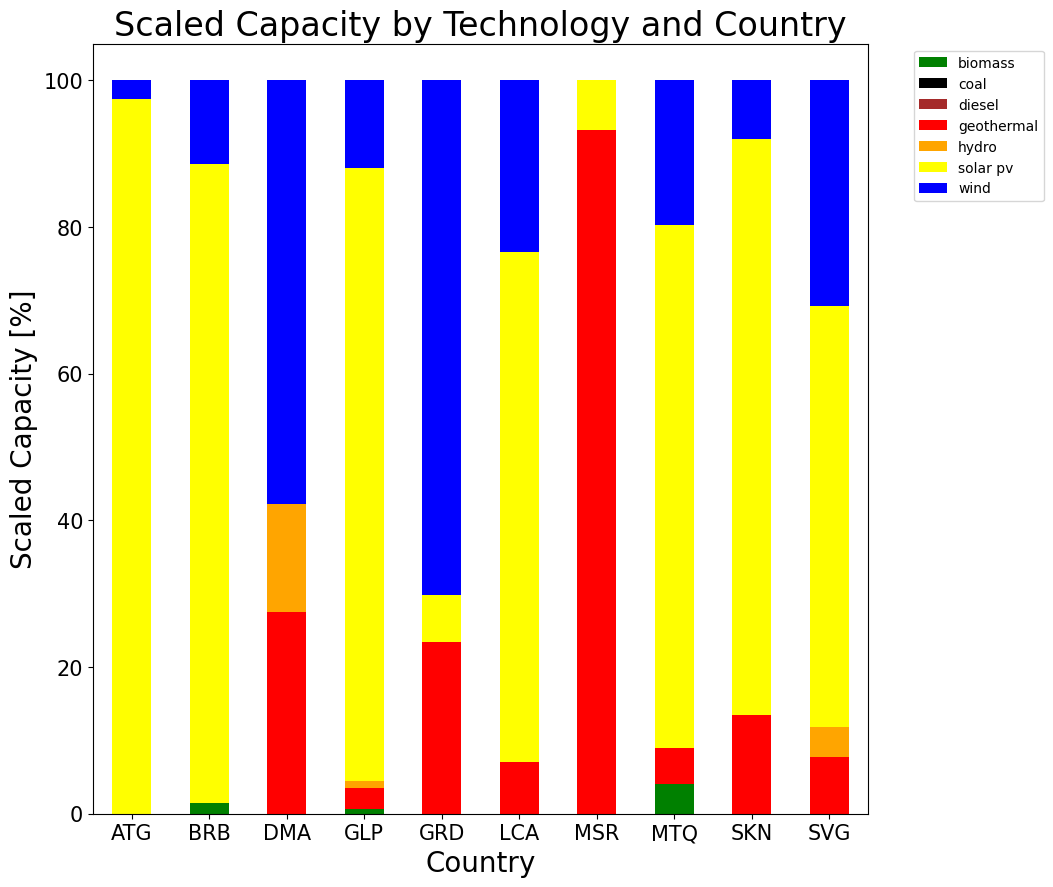

In [11]:
#plot scaled capacities by country and technology
fig, axs = plt.subplots(figsize=(10, 10))        # Create an empty Matplotlib Figure and Axes
df_cap_scaled.plot(ax = axs,kind = 'bar', color=['green','black', 'brown', 'red', 'orange','yellow', 'blue'], rot=0,stacked = True)                  # Use pandas to put the area plot on the prepared Figure/Axes
axs.tick_params(axis='both', which='major', labelsize=15)
axs.set_title("Scaled Capacity by Technology and Country",fontsize=24)
axs.set_ylabel("Scaled Capacity [%]",fontsize=20)          # Do any Matplotlib customization you like
axs.set_xlabel("Country",fontsize=20) 
axs.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.savefig(scenario+"scaled_capacity.png", bbox_inches='tight')

In [12]:
#optimum storage unit capacity [MW]
network.storage_units.p_nom_opt

name
SKN Storage     45.0
ATG Storage     70.0
MSR Storage      3.0
GLP Storage    320.0
DMA Storage     21.0
MTQ Storage    240.0
LCA Storage     75.0
BRB Storage    190.0
SVG Storage     30.0
GRD Storage     45.0
Name: p_nom_opt, dtype: float64

In [13]:
#storage units energy capacity [MWh]
network.storage_units.p_nom_opt*network.storage_units.max_hours

name
SKN Storage     360.0
ATG Storage     560.0
MSR Storage      24.0
GLP Storage    2560.0
DMA Storage     168.0
MTQ Storage    1920.0
LCA Storage     600.0
BRB Storage    1520.0
SVG Storage     240.0
GRD Storage     360.0
dtype: float64

In [14]:
#print the capacities of the links
network.links.p_nom_opt

name
SKN MSR link     0.663403
MSR ATG link     2.500000
ATG GLP link    17.954384
GLP DMA link    20.000000
DMA MTQ link     1.778738
MTQ LCA link    18.988980
LCA SVG link    12.083570
SVG GRD link     8.780822
SVG BRB link    25.000000
LCA BRB link    23.794590
Name: p_nom_opt, dtype: float64

In [15]:
#sum up generator costs by country and technology
network.generators_t.p.sum()

Generator
SKN diesel        0.000000e+00
SKN solar pv      1.903617e+05
SKN wind          4.655802e+04
SKN geothermal    3.188456e+04
ATG diesel        0.000000e+00
ATG wind          3.637413e+04
ATG solar pv      3.430538e+05
MSR diesel        0.000000e+00
MSR geothermal    1.413935e+03
MSR solar pv      4.172688e+02
GLP diesel        0.000000e+00
GLP coal          0.000000e+00
GLP hydro         9.532805e+03
GLP geothermal    1.139064e+04
GLP wind          7.714865e+05
GLP solar pv      1.264798e+06
GLP biomass       1.106023e+03
DMA diesel        0.000000e+00
DMA hydro         5.908603e+03
DMA wind          1.374692e+05
DMA solar pv      0.000000e+00
DMA geothermal    3.589931e+03
MTQ diesel        0.000000e+00
MTQ wind          8.496872e+05
MTQ solar pv      8.432056e+05
MTQ biomass       4.602137e+03
MTQ geothermal    2.898567e+04
LCA diesel        0.000000e+00
LCA wind          4.006009e+05
LCA solar pv      2.579813e+05
LCA geothermal    1.202217e+04
BRB diesel        0.000000e+0

In [16]:
#calculate total generation for the region
(network.generators_t.p.sum()).sum()

6799810.609999999

In [17]:
#reshape dataframe for storage costs by country 
df_storage_cost = pd.DataFrame(network.storage_units.p_nom_opt*network.storage_units.capital_cost)
df_storage_cost.columns = ['storage_cost']
df_storage_cost = df_storage_cost.reset_index()
#df_storage_cost

In [18]:
#reshape storage costs dataframe
new = df_storage_cost["name"].str.split(" ", n = 1, expand = True)
df_storage_cost["Tech"]= new[1]
df_storage_cost['Country']= new[0]
df_storage_cost.drop(columns =["name"], inplace = True)
df_storage_cost= df_storage_cost.pivot(index = 'Country',columns = 'Tech', values = 'storage_cost')
#df_storage_cost 

In [19]:
#reshape dataframe for generator costs 
df_cost=pd.DataFrame((network.generators.p_nom_opt*network.generators.capital_cost)+(network.generators_t.p.sum()*network.generators.marginal_cost))
df_cost.columns = ['generator_cost']
df_cost = df_cost.reset_index()
#df_cost

In [20]:
#reshape dataframe for generator and storage costs
new1 = df_cost["name"].str.split(" ", n = 1, expand = True)
df_cost["Technology"]= new1[1]
df_cost['Country']= new1[0]
df_cost.drop(columns =["name"], inplace = True)
df_cost = df_cost.pivot(index = 'Country',columns = 'Technology', values = 'generator_cost')
#extracted_col = pd.DataFrame(df_storage_cost['storage_cost'])
#extracted_col
df_cost = df_cost.join(df_storage_cost['Storage'])
df_cost


,biomass,coal,diesel,geothermal,hydro,solar pv,wind,Storage
Country,,,,,,,,
ATG,NaN,NaN,0.0,NaN,NaN,2.803564e+07,1.131560e+06,5214510.0
BRB,4.989991e+06,NaN,0.0,NaN,NaN,4.319004e+07,8.720700e+06,14153670.0
DMA,NaN,NaN,0.0,1.117217e+07,1.342830e+06,0.000000e+00,3.661247e+06,1564353.0
GLP,4.914843e+06,0.0,0.0,3.722906e+07,2.502348e+06,1.074369e+08,2.364455e+07,23837760.0
GRD,NaN,NaN,0.0,1.506417e+07,0.000000e+00,4.132708e+05,6.976560e+06,3352185.0
LCA,NaN,NaN,0.0,2.244119e+07,NaN,2.251727e+07,1.162760e+07,5586975.0
MSR,NaN,NaN,0.0,2.559277e+06,NaN,1.894300e+04,NaN,223479.0
MTQ,2.035070e+07,NaN,0.0,3.758096e+07,NaN,5.471020e+07,2.325520e+07,17878320.0
SKN,NaN,NaN,0.0,1.473931e+07,NaN,8.440436e+06,1.311474e+06,3352185.0


In [21]:
#reshape dataframe for actual generation by country and technology (in GWh)
df_gen=pd.DataFrame(network.generators_t.p.sum()/1000)
df_gen = df_gen.reset_index()
df_gen.columns = ['name','Electricity']
new = df_gen["name"].str.split(" ", n = 1, expand = True)
df_gen["Technology"]= new[1]
df_gen['Country']= new[0]
df_gen.drop(columns =["name"], inplace = True)
df_gen= df_gen.pivot(index = 'Country',columns = 'Technology', values = 'Electricity')
df_gen

Technology,biomass,coal,diesel,geothermal,hydro,solar pv,wind
Country,,,,,,,
ATG,NaN,NaN,0.0,NaN,NaN,343.053789,36.374131
BRB,1.642792,NaN,0.0,NaN,NaN,624.487950,315.523835
DMA,NaN,NaN,0.0,3.589931,5.908603,0.000000,137.469196
GLP,1.106023,0.0,0.0,11.390638,9.532805,1264.797825,771.486458
GRD,NaN,NaN,0.0,13.183437,0.000000,6.752992,241.654651
LCA,NaN,NaN,0.0,12.022174,NaN,257.981322,400.600851
MSR,NaN,NaN,0.0,1.413935,NaN,0.417269,NaN
MTQ,4.602137,NaN,0.0,28.985669,NaN,843.205632,849.687152
SKN,NaN,NaN,0.0,31.884556,NaN,190.361733,46.558019


In [22]:
#reshape link costs dataframe
df_link_cost = pd.DataFrame(network.links.p_nom_opt*network.links.capital_cost)
df_link_cost.columns = ['link_cost']
df_link_cost = df_link_cost.reset_index()
#df_link_cost

In [23]:
#calculate total link costs
df_link_cost.link_cost.sum()


13986317.830724698

In [24]:
#calculate LCOE for each country separately but without transmission link costs
df_cost.sum(axis=1)/df_gen.sum(axis=1)/1000

Country
ATG      90.614603
BRB      75.456970
DMA     120.710877
GLP      96.955806
GRD      98.650858
LCA      92.711953
MSR    1529.976817
MTQ      89.068698
SKN     103.582424
SVG      87.989864
dtype: float64

In [25]:
(df_gen.sum()).sum()

6799.81061

In [26]:
(df_gen.sum(axis=1))

Country
ATG     379.427920
BRB     941.654576
DMA     146.967730
GLP    2058.313749
GRD     261.591080
LCA     670.604347
MSR       1.831204
MTQ    1726.480590
SKN     268.804309
SVG     344.135105
dtype: float64

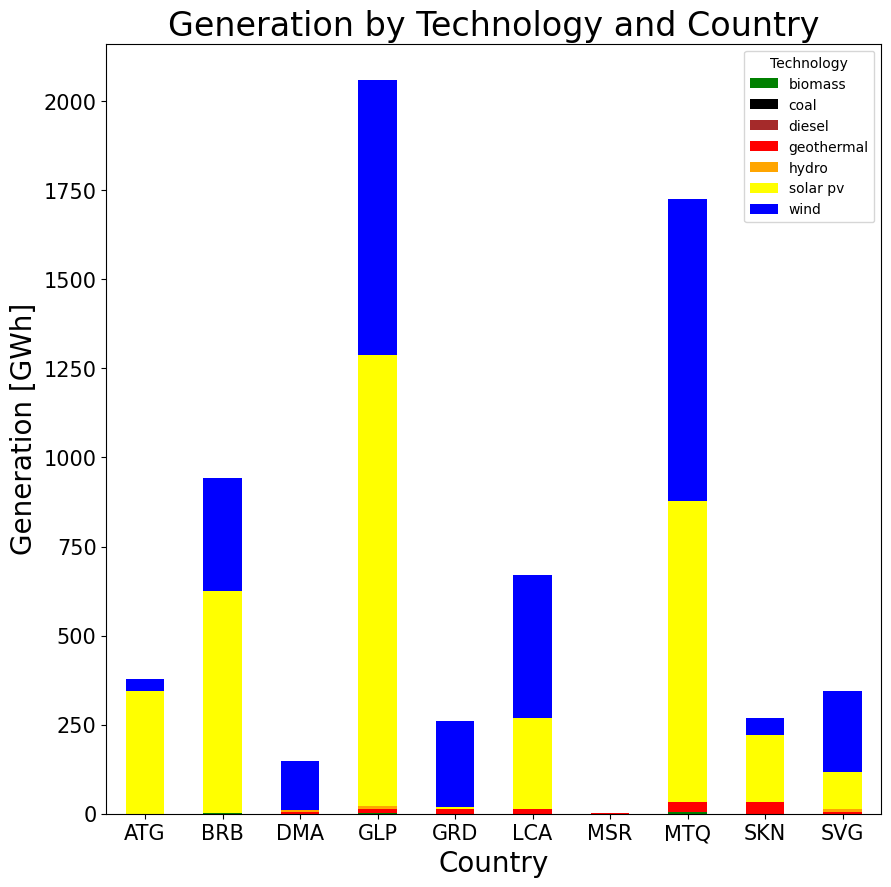

In [27]:
#plot the actual generation by country and technology [GWh]
fig, axs = plt.subplots(figsize=(10, 10))        # Create an empty Matplotlib Figure and Axes
df_gen.plot(ax = axs,kind = 'bar', color=['green','black', 'brown', 'red', 'orange','yellow', 'blue'], rot=0,stacked = True)                  # Use pandas to put the area plot on the prepared Figure/Axes
axs.tick_params(axis='both', which='major', labelsize=15)
axs.set_title("Generation by Technology and Country",fontsize=24)
axs.set_ylabel("Generation [GWh]",fontsize=20)          # Do any Matplotlib customization you like
axs.set_xlabel("Country",fontsize=20) 
fig.savefig(scenario+"generation.png", bbox_inches='tight') 

In [28]:
#scaled the generation output by country and technology
df_gen_scaled = df_gen.div(df_gen.sum(axis=1), axis=0)*100

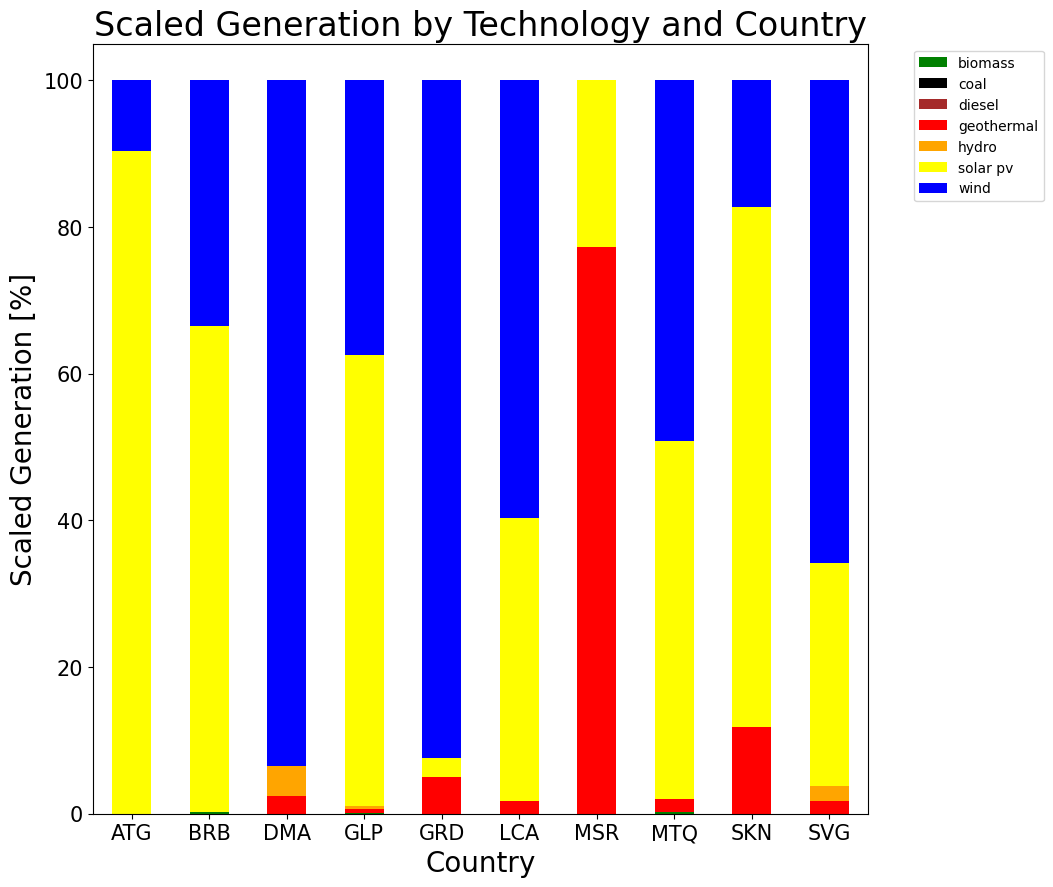

In [29]:
#plot the scaled output by technology and country
fig, axs = plt.subplots(figsize=(10, 10))        # Create an empty Matplotlib Figure and Axes
df_gen_scaled.plot(ax = axs,kind = 'bar', color=['green','black', 'brown', 'red', 'orange','yellow', 'blue'], rot=0,stacked = True)                  # Use pandas to put the area plot on the prepared Figure/Axes
axs.tick_params(axis='both', which='major', labelsize=15)
axs.set_title("Scaled Generation by Technology and Country",fontsize=24)
axs.set_ylabel("Scaled Generation [%]",fontsize=20)          # Do any Matplotlib customization you like
axs.set_xlabel("Country",fontsize=20) 
axs.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
fig.savefig(scenario+"scaled_generation.png", bbox_inches='tight') 

In [30]:
#network.generators_t.p.sum()/(network.generators_t.p.sum()).sum()

In [31]:
#calculate capacity factors by country and technology
#network.generators_t.p.sum()/(network.generators.p_nom_opt*8760)

In [32]:
#calculate regional LCOE
((network.generators.p_nom_opt*network.generators.capital_cost).sum()+(network.generators_t.p.sum()*network.generators.marginal_cost).sum()+(network.storage_units.p_nom_opt*network.storage_units.capital_cost).sum()+df_link_cost.link_cost.sum()).sum()/(network.loads_t.p_set.sum()).sum()

94.03329624479558

In [33]:
((network.generators.p_nom_opt*network.generators.capital_cost).sum()+(network.generators_t.p.sum()*network.generators.marginal_cost).sum()+(network.storage_units.p_nom_opt*network.storage_units.capital_cost).sum())/network.loads_t.p_set.sum()

Load
SKN load     2289.390742
MSR load    38157.562278
ATG load     1431.119754
GLP load      312.216250
DMA load     4906.007784
MTQ load      343.436087
LCA load     1321.018672
SVG load     3434.186053
GRD load     2368.856023
BRB load      520.351766
dtype: float64

<Axes: xlabel='snapshot'>

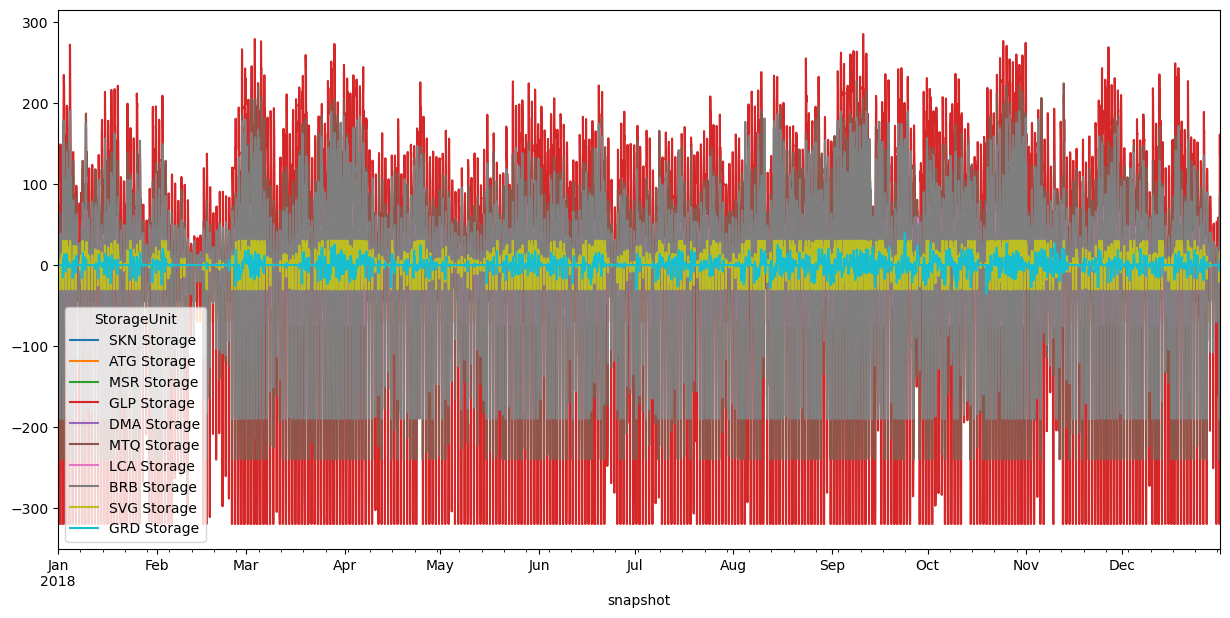

In [34]:
#print storage units
network.storage_units_t.p.plot(figsize = (15,7))

